In [1]:
import maboss
from tqdm import tqdm
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
ensemble = maboss.Ensemble(path = '/home/spankaew/Git/BooleanBenchmark/models/test_bonesis')

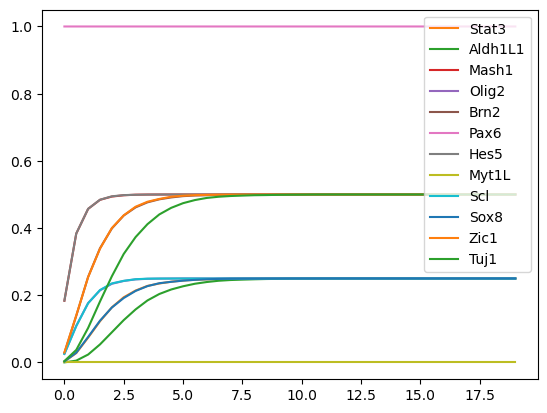

In [39]:
model = maboss.loadBNet('/home/spankaew/Git/BooleanBenchmark/models/test_bonesis/bn1.bnet')
model.network.set_istate('Pax6',[0,1])
model.update_parameters(max_time = 20)
simulation = model.run()
simulation.plot_node_trajectory()

In [19]:
# Create blank file to get the results
ensemble_results = {}

# Set model path
path = '/home/spankaew/Git/BooleanBenchmark/models/test_bonesis/' 
model_list = os.listdir(path)

# Get node list
node_list = list(model.network.names)
node_list.remove('Pax6')

for model in tqdm(model_list):

    # Load model
    simulations = maboss.loadBNet(path + model)

    # Setup the model initial condition
    ## Put all inputs at random
    simulations.network.set_istate('Pax6',[0,1])
    for i in node_list:
        simulations.network.set_istate(i,[1,0])
        
    # Modify the parameter of the model
    simulations.update_parameters(sample_count = 10000,
                                  thread_count = 15,
                                  max_time = 20,
                                  time_tick = 1)
    simulations.network.set_output(simulations.network.names)

    # Perform simulations
    result = simulations.run()

    # Get matrix
    model_mtx = result.get_nodes_probtraj().copy()

    # Setup cell matrix
    ## Cells
    model_mtx['model_id'] = model.replace('.bnet','')
    ## Timepoint
    model_mtx['timepoint'] = model_mtx.index
    ## Change index
    model_mtx.index = model_mtx.index.map(str)
    model_mtx.index = model + '_' + model_mtx.index

    # Concatenate model results in dictionary
    ensemble_results[model] = model_mtx

100%|██████████| 88/88 [00:07<00:00, 11.66it/s]


In [20]:
import pandas as pd
simulation_df = pd.concat(ensemble_results.values(), ignore_index = True)
simulation_df.to_csv('/home/spankaew/Git/BooleanBenchmark/tmp/test_bonesis_simulation.csv')

In [21]:
cl_df = pd.read_csv('/home/spankaew/Git/BooleanBenchmark/tmp/test_bonesis_simulation.csv', index_col = 0)
cl_df.index = cl_df.model_id + '_' + [str(f) for f in cl_df.timepoint]
cl_df.index.name = None

In [22]:
adata = sc.AnnData(cl_df.drop(['model_id','timepoint'],axis = 1))
adata.obs['timepoint'] = cl_df['timepoint']
adata.obs['model_id'] = cl_df['model_id']

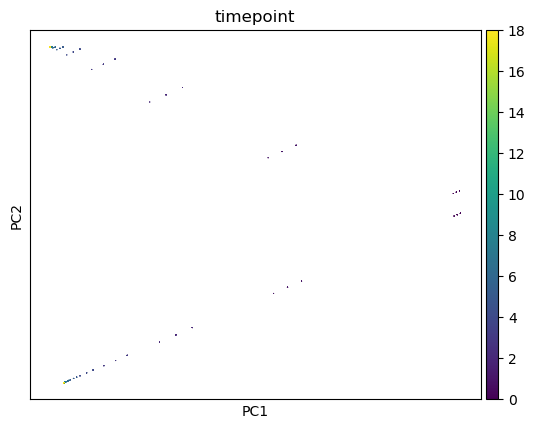

In [23]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color = 'timepoint', size = 2)

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-

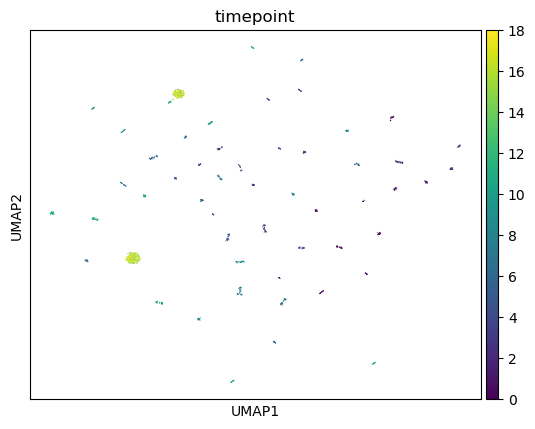

In [24]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color="timepoint",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

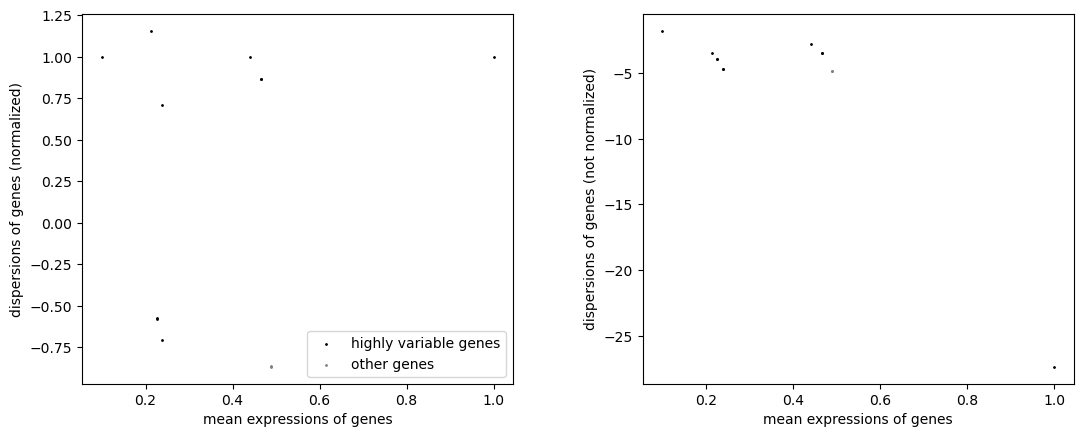

In [25]:
sc.pp.highly_variable_genes(adata, n_top_genes=10)
sc.pl.highly_variable_genes(adata)

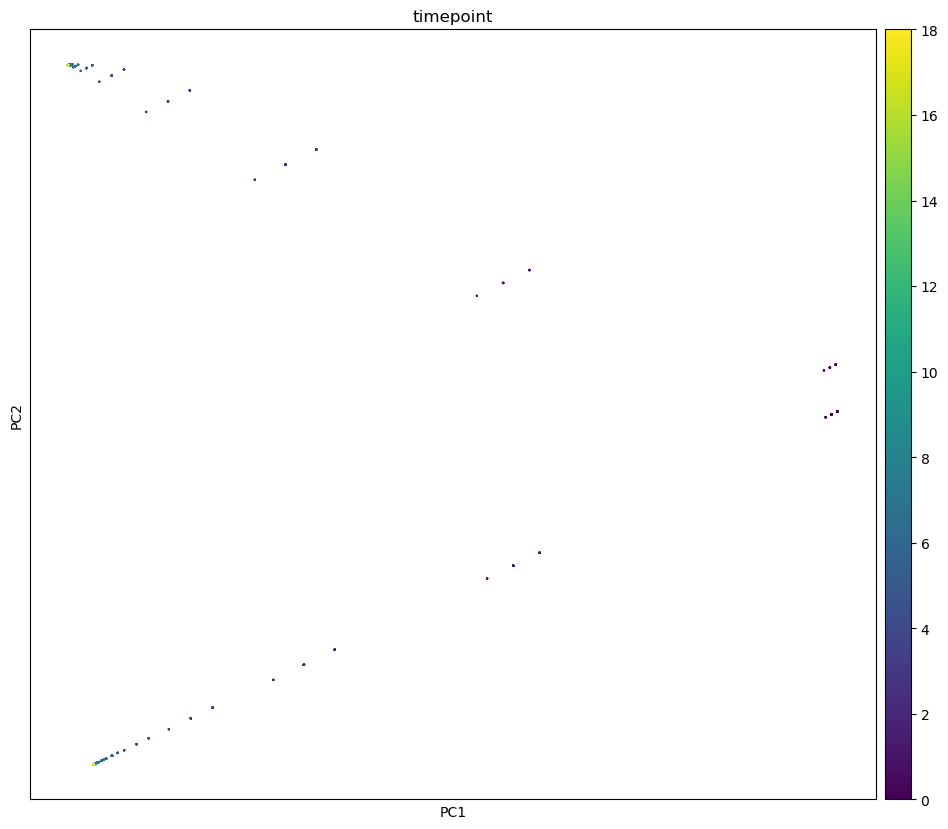

In [26]:
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (12, 10)}):
    sc.pl.pca(adata, color = 'timepoint', size = 10)

In [27]:
pca_mat = [array[:2] for array in adata.obsm['X_pca']]
pca_mat = pd.DataFrame(pca_mat, columns= ['pca1','pca2'])
pca_mat.index = adata.obs.index
pca_mat = pd.concat([pca_mat, adata.obs], axis = 1,ignore_index = False)

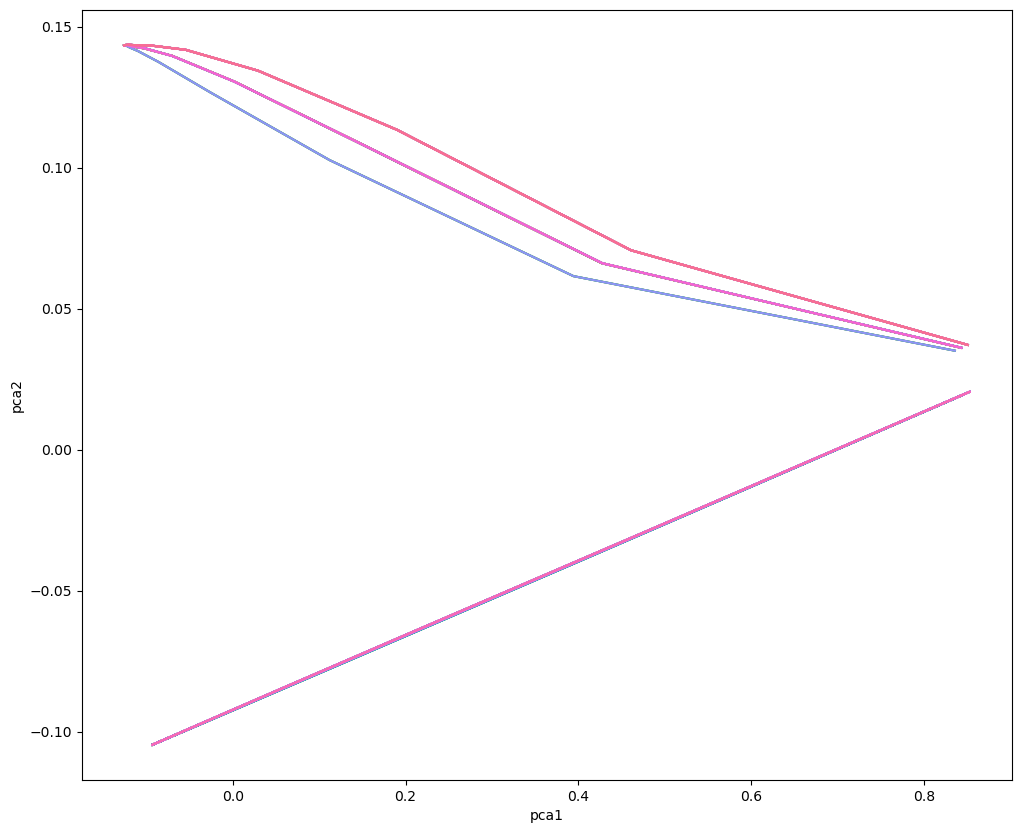

In [28]:
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, x = 'pca1',y='pca2',hue = 'model_id', sort = False)
    plot.get_legend().remove()

plt.show()

In [12]:
umap_mat = [array[:2] for array in adata.obsm['X_umap']]
umap_mat = pd.DataFrame(umap_mat, columns= ['umap1','umap2'])
umap_mat.index = adata.obs.index
umap_mat = pd.concat([umap_mat, adata.obs], axis = 1,ignore_index = False)
umap_mat

,umap1,umap2,timepoint,model_id
Invasion_532_0.0,5.236312,15.101437,0.0,Invasion_532
Invasion_532_1.0,-4.637139,6.617371,1.0,Invasion_532
Invasion_532_2.0,9.843303,17.624397,2.0,Invasion_532
Invasion_532_3.0,7.039475,-10.601682,3.0,Invasion_532
Invasion_532_4.0,-12.781754,10.379288,4.0,Invasion_532
...,...,...,...,...
Invasion_799_14.0,3.311070,3.064426,14.0,Invasion_799
Invasion_799_15.0,3.520934,3.586459,15.0,Invasion_799
Invasion_799_16.0,3.670121,3.969983,16.0,Invasion_799
Invasion_799_17.0,3.928044,4.234212,17.0,Invasion_799


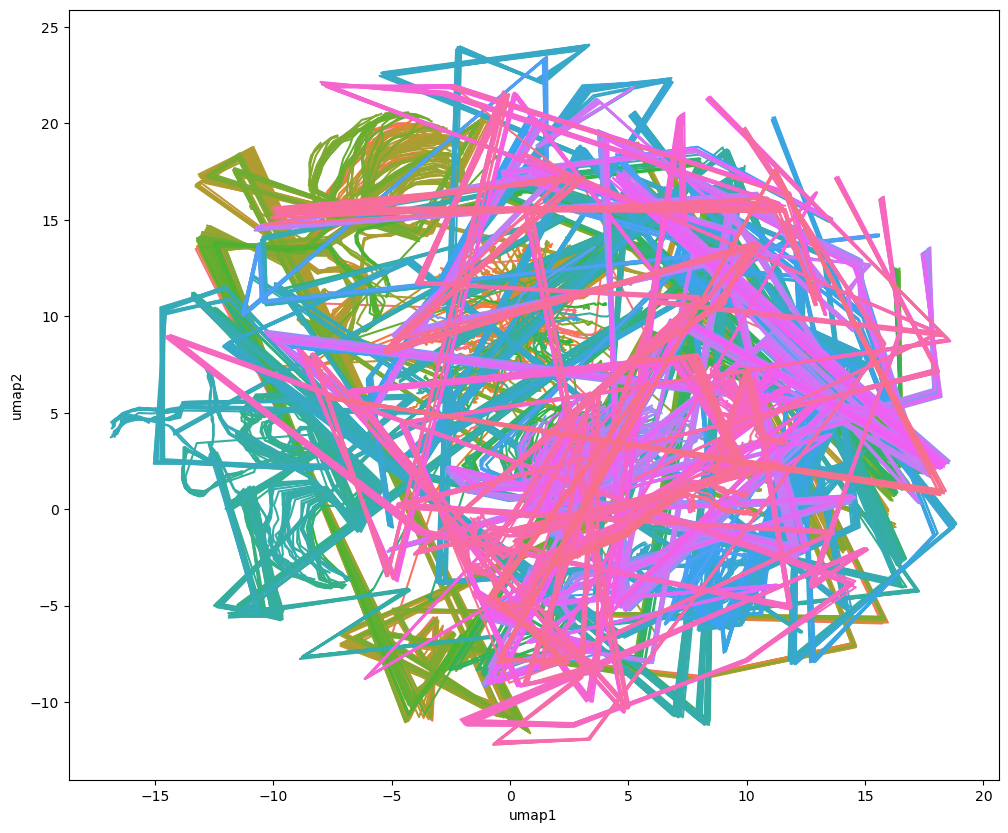

In [117]:
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = umap_mat, x = 'umap1',y='umap2',hue = 'model_id', sort = False)
    plot.get_legend().remove()

plt.show()

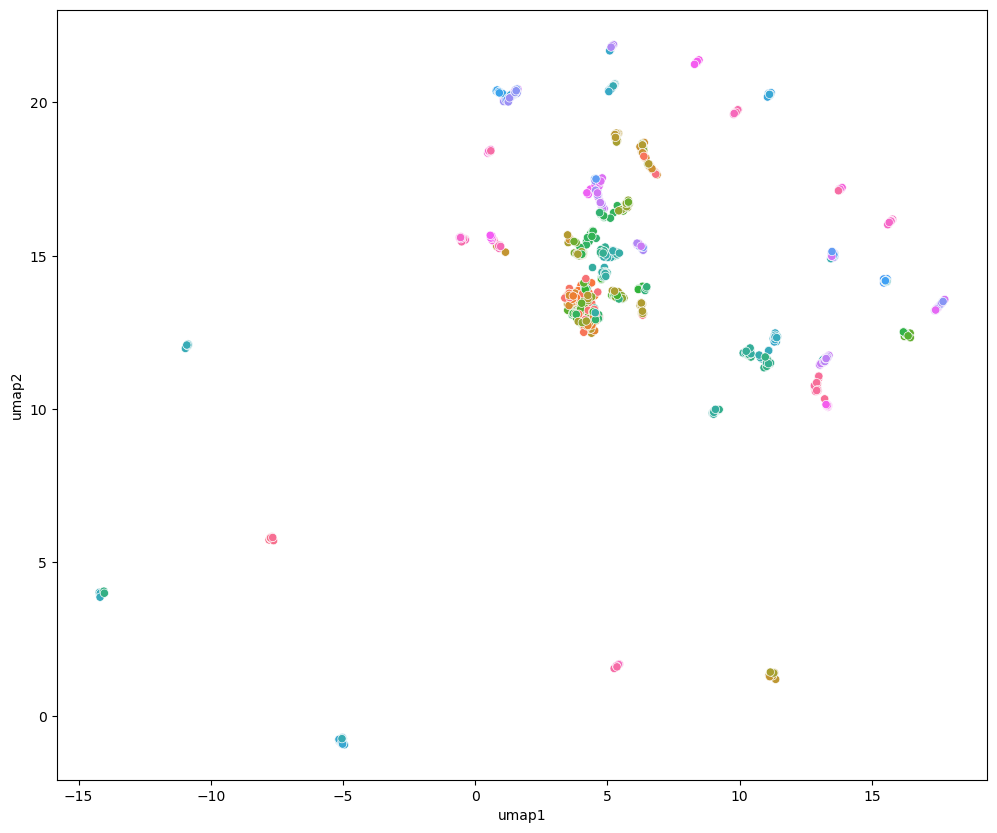

In [145]:

import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.scatterplot(data = umap_mat.loc[umap_mat.timepoint == 0], x = 'umap1',y='umap2',hue = 'model_id')
    plot.get_legend().remove()

plt.show()

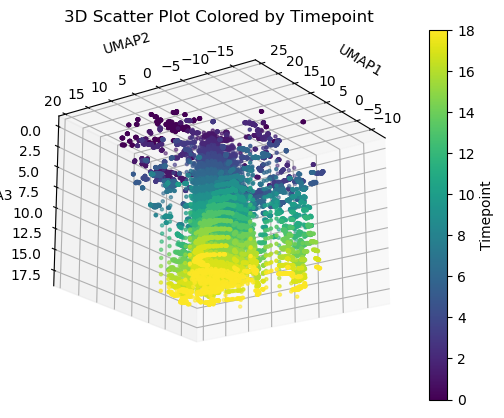

In [122]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with coloring based on 'timepoint'
scatter = ax.scatter(umap_mat['umap2'], 
                     umap_mat['umap1'],
                     umap_mat['timepoint'],
                     c=umap_mat['timepoint'], s = 5)

# Labels and title
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('PCA3')
ax.set_title('3D Scatter Plot Colored by Timepoint')
ax.view_init(elev=20., azim=-35, roll=180)

# Color bar
plt.colorbar(scatter, ax=ax, label='Timepoint')

# Show plot
plt.show()


# Trajectory comparison using single variable from PCA

In [29]:
import tslearn
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesResampler
import numpy


seed = 0
numpy.random.seed(seed)

Euclidean k-means
0.003 --> 0.002 --> 0.002 --> 


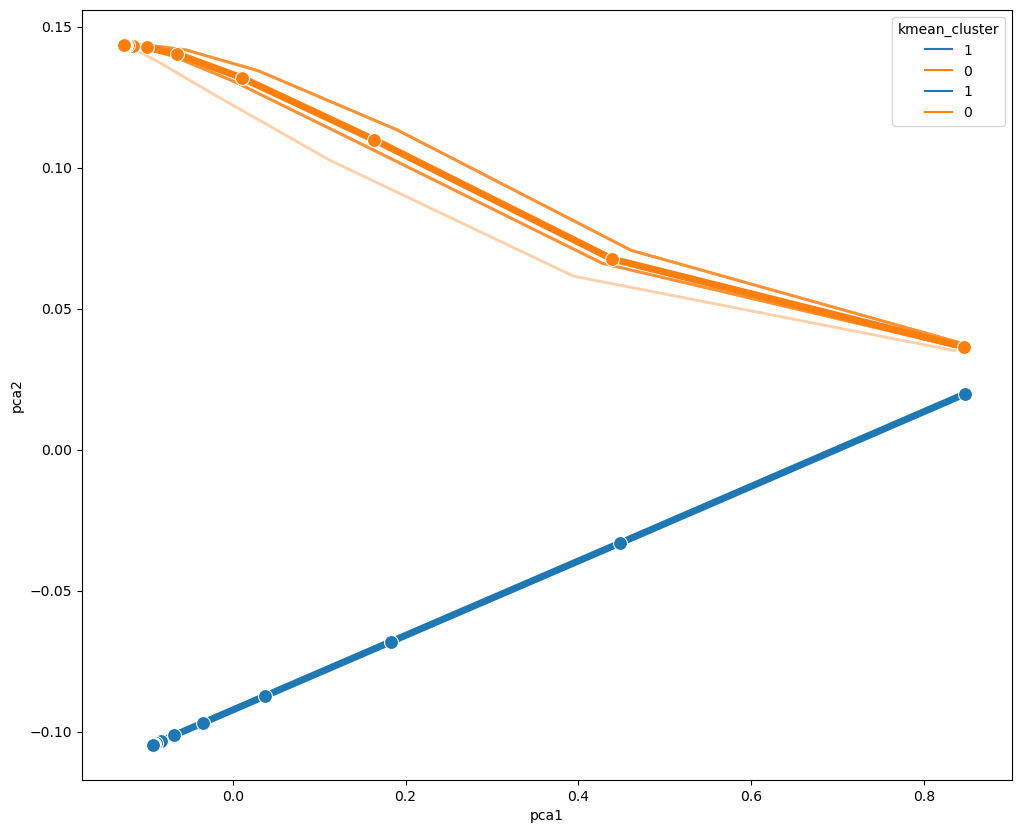

In [31]:
model_name = pca_mat.model_id.cat.categories

model_pca_all = {}
for i in model_name:
    model_pca = pca_mat.loc[pca_mat.model_id == i,['pca1','pca2']].values
    model_pca_all[i] = numpy.array(model_pca)

pca_all_trajectory = numpy.array(list(model_pca_all.values()))

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=2, verbose=True, random_state=seed)
y_pred = km.fit_predict(pca_all_trajectory)


# Plot the trajectory
cluster_dict = dict(zip(list(model_name),list(y_pred)))
pca_mat['kmean_cluster'] = pca_mat['model_id']
pca_mat['kmean_cluster'] = pca_mat['kmean_cluster'].replace(cluster_dict)

## Calculate the mean position
kmean_cluster = pca_mat.groupby(['timepoint','kmean_cluster'])[['pca1','pca2']].mean()

## Plot with Seaborn
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
                        sort = False)
    plot.get_legend().remove()

    plot2 = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

In [48]:
y_pred.sum()

52

In [32]:
import itertools
value = list(range(10))
combinations = list(itertools.combinations(value,2))

In [33]:
pca_mat

,pca1,pca2,timepoint,model_id,kmean_cluster
bn45_0.0,0.843482,0.036116,0.0,bn45,0
bn45_1.0,0.427703,0.066083,1.0,bn45,0
bn45_2.0,0.150883,0.108023,2.0,bn45,0
bn45_3.0,0.001397,0.130534,3.0,bn45,0
bn45_4.0,-0.070305,0.139594,4.0,bn45,0
...,...,...,...,...,...
bn15_14.0,-0.092952,-0.104639,14.0,bn15,1
bn15_15.0,-0.092952,-0.104639,15.0,bn15,1
bn15_16.0,-0.092952,-0.104639,16.0,bn15,1
bn15_17.0,-0.092952,-0.104639,17.0,bn15,1


In [34]:
kmean_cluster = pca_mat.groupby(['kmean_cluster','timepoint'])[['pca1','pca2']].mean()

In [35]:
# Calculate Euclidean distances between clusters
distance_matrix = pd.DataFrame()
for i in list(range(10)):
    time_series1 = numpy.array(kmean_cluster.loc[i])
    distance_cluster = []
    for j in list(range(10)):
        time_series2 = numpy.array(kmean_cluster.loc[j])
        distance = numpy.sqrt(numpy.sum((time_series1 - time_series2)**2))
        distance_cluster.append(distance)
    distance_matrix = pd.concat([distance_matrix,pd.DataFrame(distance_cluster)],axis = 1)
distance_matrix.columns = list(range(10))

# Plot Euclidean distance using clustermap
sns.clustermap(distance_matrix, annot=True)

plt.show()

KeyError: 2

In [31]:
cluster_distance_reset = cluster_distance.reset_index()
distance_matrix = pd.melt(cluster_distance_reset, id_vars=['index'], var_name = 'Kmean_cluster', value_name = 'Euclidean distance')
distance_matrix

,index,Kmean_cluster,Euclidean distance
0,0,0,0.000000
1,1,0,0.000000
2,2,0,0.000000
3,3,0,0.000000
4,4,0,0.000000
...,...,...,...
185,14,9,0.112385
186,15,9,0.112208
187,16,9,0.111354
188,17,9,0.110593


<Axes: xlabel='index', ylabel='Euclidean distance'>

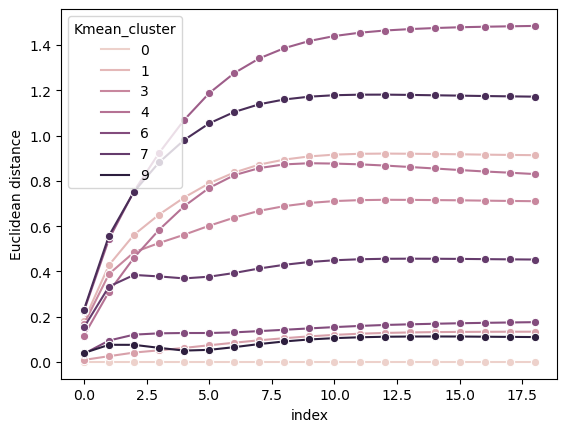

In [32]:
sns.lineplot(distance_matrix, x = 'index', y = 'Euclidean distance', hue = 'Kmean_cluster', marker = 'o')

In [36]:
time_series1 = numpy.array(kmean_cluster.loc[0])
cluster_distance = pd.DataFrame()

for i in list(range(10)):
    time_series2 = numpy.array(kmean_cluster.loc[i])

    distance = pd.DataFrame(((time_series1 - time_series2))**2)
    distance = numpy.sqrt(distance[0] + distance[1])
    cluster_distance = pd.concat([cluster_distance,distance], axis = 1)
cluster_distance.columns = list(range(10))

sns.clustermap(cluster_distance, row_cluster=False, linewidth = .5, linecolor = 'black')

KeyError: 2

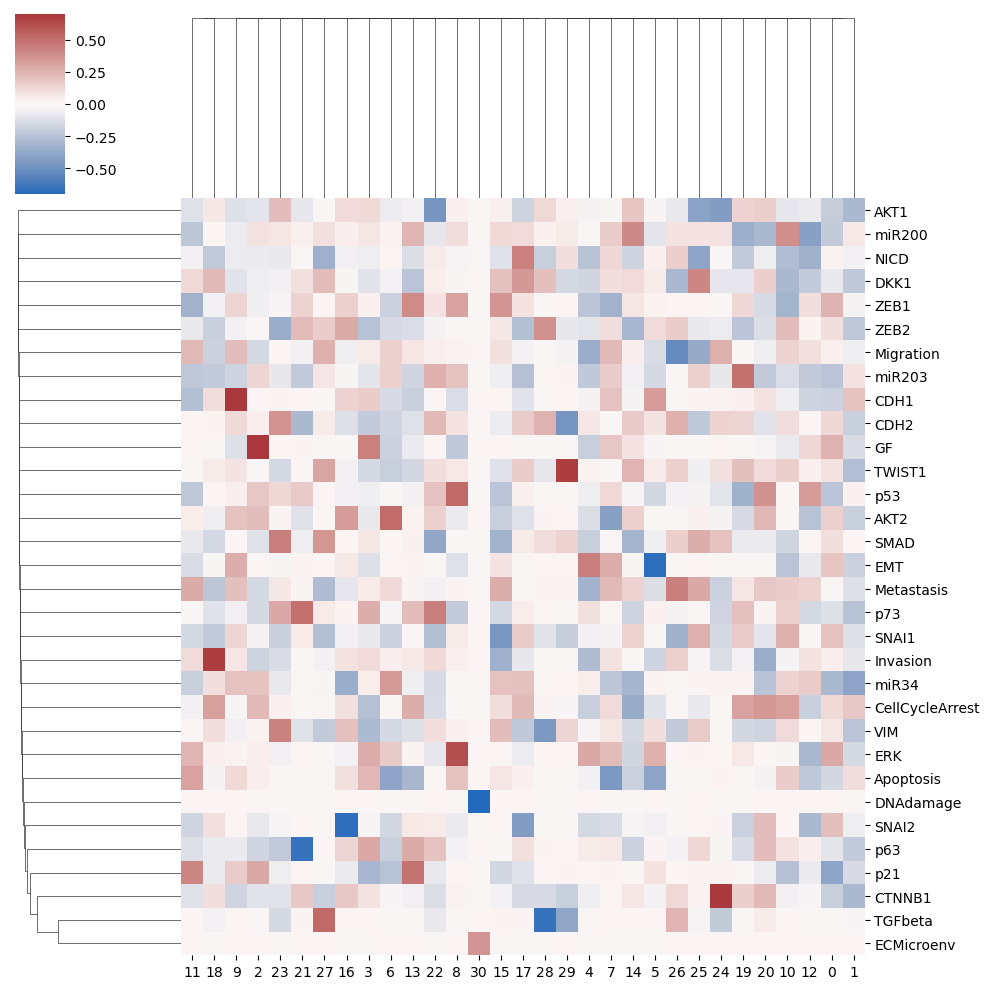

In [182]:
test = pd.DataFrame(adata.varm['PCs'])
test.index = list(adata.var_names)
sns.clustermap(test, cmap = 'vlag', vmax = .7, vmin = -.7)

'bn15.bnet'

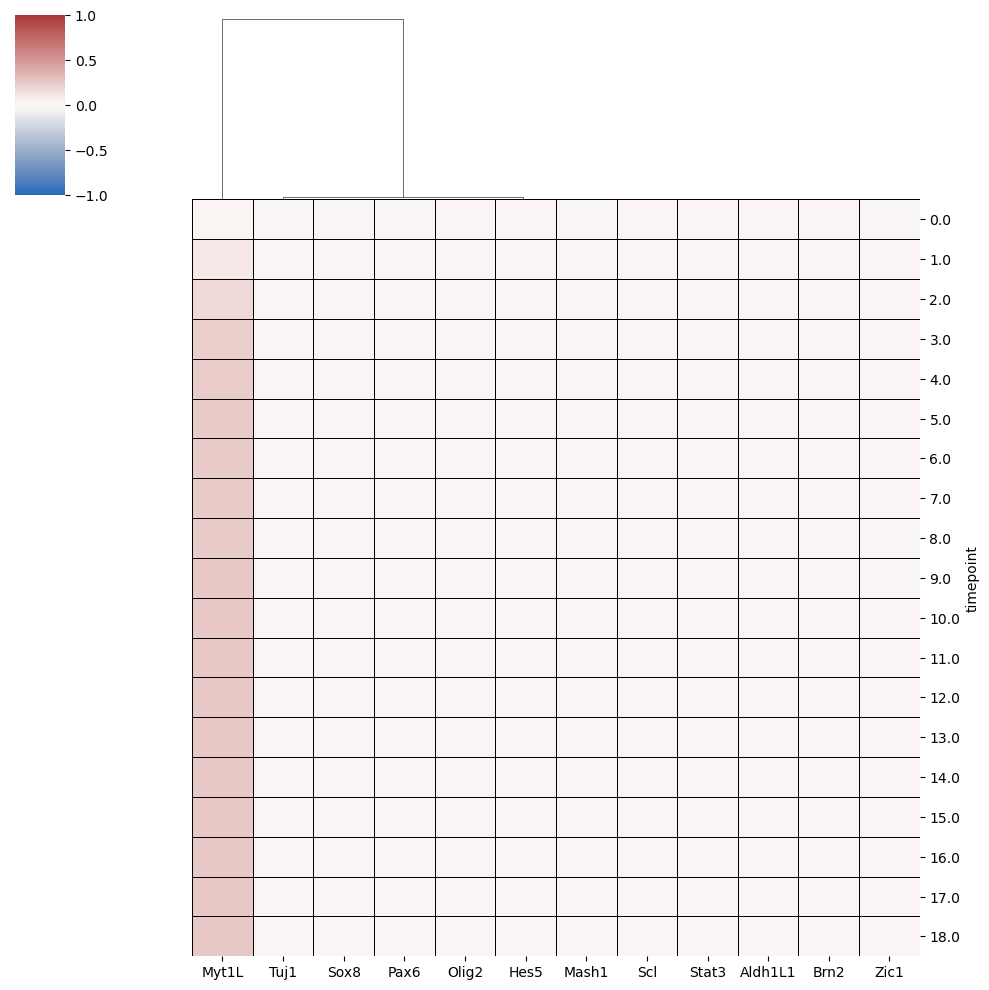

In [49]:
cl_df['kmean_cluster'] = cl_df['model_id']
cl_df['kmean_cluster'] = cl_df['kmean_cluster'].replace(cluster_dict)


test1 = cl_df[cl_df['kmean_cluster']==0]
test1 = test1.groupby(['kmean_cluster','timepoint'])[model.network.names].mean()
test1 = test1.reset_index(level = 'kmean_cluster').drop(columns = ['kmean_cluster'])

test9 = cl_df[cl_df['kmean_cluster']==1]
test9 = test9.groupby(['kmean_cluster','timepoint'])[model.network.names].mean()
test9 = test9.reset_index(level = 'kmean_cluster').drop(columns = ['kmean_cluster'])

test = test1-test9
sns.clustermap(test, row_cluster=False, cmap ='vlag', vmax = 1, vmin = -1, linecolor= 'black', linewidth =.5)

In [ ]:
import seaborn as sns 

diff_df = sen_df.loc['resistant',:] - sen_df.loc['sensitive',:]
# When plotting the second dataset, we use the previously computed linkage matrix:
cg2 = sns.clustermap(diff_df.transpose(), 
                     row_cluster=True, 
                     col_cluster = False,
                     figsize = (8,22),cmap = 'coolwarm',vmax = 1, vmin = -1)


#plt.savefig('/home/spankaew/pyPROFILE/figures/figure_01/Fig_1D_3.pdf')
plt.show()
#plt.close()

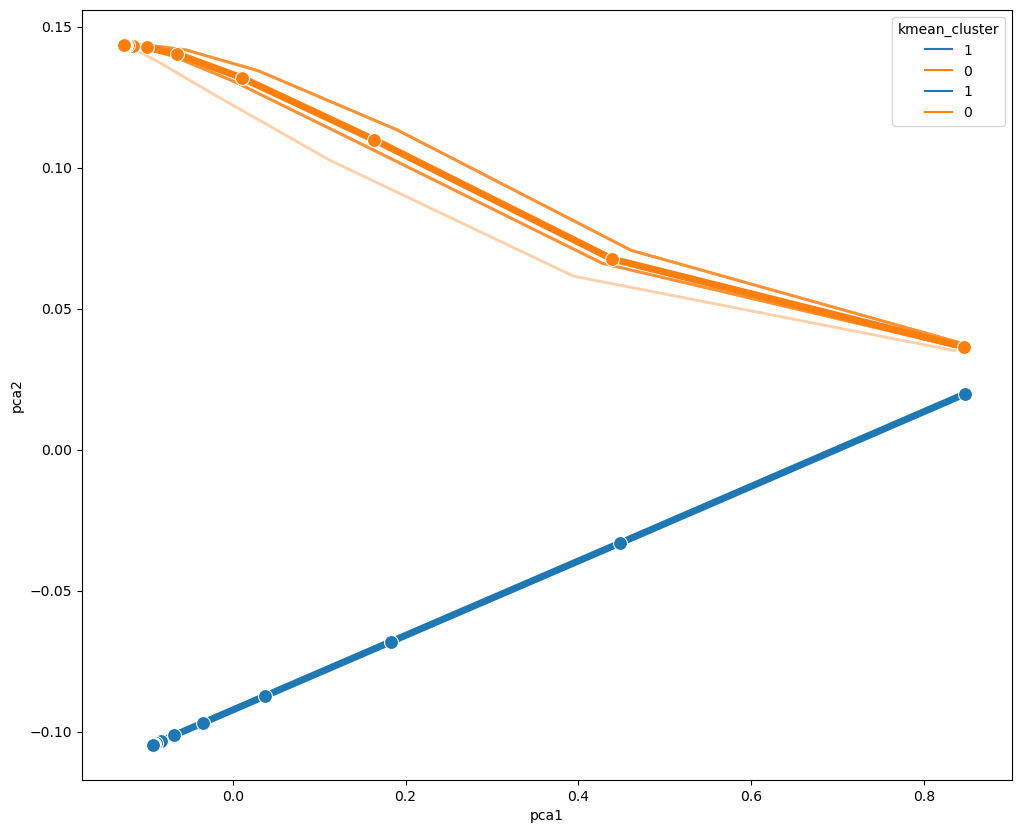

In [50]:
## Plot with Seaborn
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
                        sort = False)
    plot.get_legend().remove()

    plot2 = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

In [92]:
time_series1 = numpy.array(kmean_cluster.loc[combinations[0][0]])
time_series2 = numpy.array(kmean_cluster.loc[combinations[0][1]])
distance = numpy.sqrt(numpy.sum((time_series1 - time_series2)**2))

3.5732815

In [41]:
model_name = pca_mat.model_id.cat.categories

model_pca_all = {}
for i in model_name:
    model_pca = pca_mat.loc[pca_mat.model_id == i,['pca1','pca2']].values
    model_pca_all[i] = numpy.array(model_pca)

pca_all_trajectory = numpy.array(list(model_pca_all.values()))

# Euclidean k-means
print("Euclidean k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=10,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(pca_all_trajectory)


# Plot the trajectory
cluster_dict = dict(zip(list(model_name),list(y_pred)))
pca_mat['softdtw_cluster'] = pca_mat['model_id']
pca_mat['softdtw_cluster'] = pca_mat['softdtw_cluster'].replace(cluster_dict)

# Calculate the mean position
kmean_cluster = pca_mat.groupby(['timepoint','kmean_cluster'])[['pca1','pca2']].mean()

import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'softdtw_cluster', units = 'model_id', estimator = None, lw=2, alpha = .2,
                        sort = False)
    #plot.get_legend().remove()
    plot = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)


plt.show()

Euclidean k-means


KeyboardInterrupt: 

- Find mean PCA postion for each clusters 

- Find mean Euclidean distance at each timestpes between clusters

In [21]:
kmean_dist = pca_mat.groupby(['timepoint','kmean_cluster'])['pca1'].mean()
kmean_dist = pd.DataFrame(kmean_dist).pivot_table(values = 'pca1', index=  'timepoint', columns = 'kmean_cluster')
kmean_dist = 

kmean_cluster,9,3,6,1,7,8,5,0,4,2
timepoint,,,,,,,,,,
0.0,-0.811310,-0.628888,-0.752504,-0.608179,-0.643923,-0.557204,-0.563009,-0.787635,-0.757462,-0.780017
1.0,-0.640837,-0.236792,-0.515557,-0.180362,-0.298110,-0.048364,-0.070186,-0.606232,-0.615483,-0.582408
2.0,-0.461301,0.029892,-0.332011,0.116608,-0.081567,0.298649,0.274873,-0.444944,-0.574737,-0.404808
3.0,-0.311572,0.207336,-0.203280,0.319193,0.054233,0.528206,0.519450,-0.318047,-0.595091,-0.268268
4.0,-0.196853,0.326851,-0.114142,0.455367,0.141257,0.679196,0.698075,-0.227322,-0.639663,-0.168405
5.0,-0.113015,0.407480,-0.053206,0.545761,0.199600,0.776823,0.829273,-0.163815,-0.682904,-0.095147
6.0,-0.053606,0.461894,-0.009859,0.605777,0.239359,0.838507,0.924907,-0.118798,-0.714584,-0.041100
7.0,-0.012060,0.498008,0.020189,0.645000,0.267286,0.876979,0.993253,-0.088874,-0.733144,-0.003220
8.0,0.017610,0.521778,0.042571,0.670051,0.286874,0.901096,1.042430,-0.067700,-0.741677,0.024566


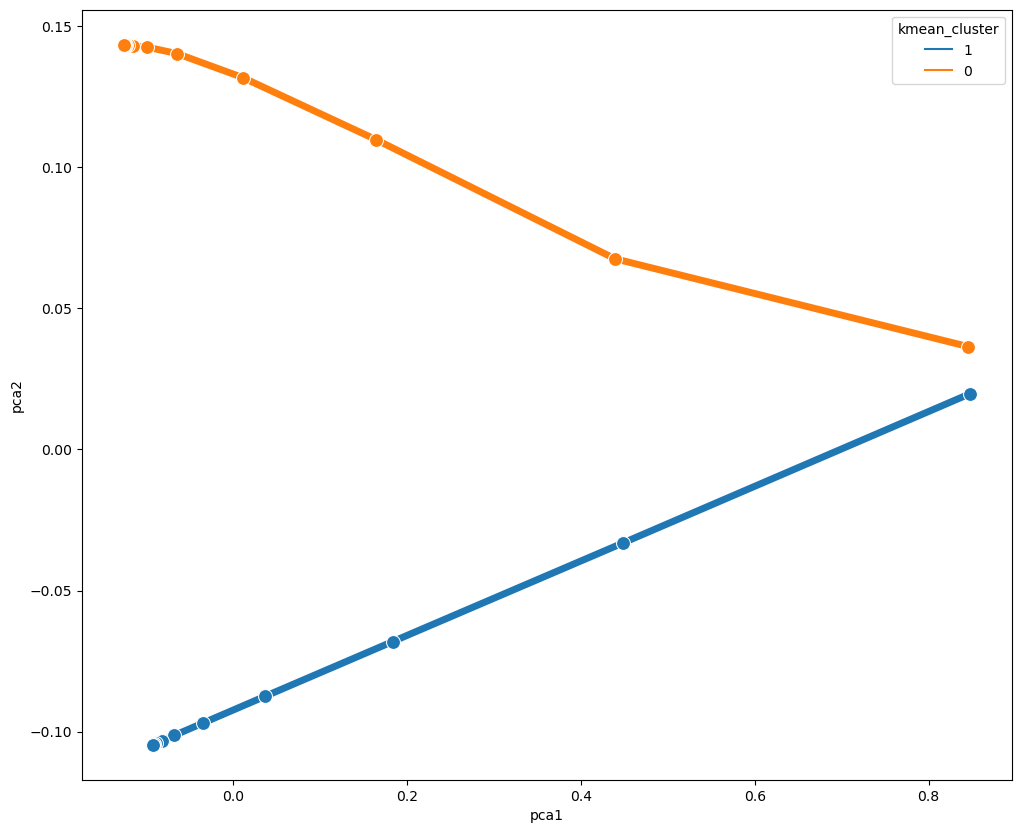

In [96]:
kmean_cluster = pca_mat.groupby(['timepoint','kmean_cluster'])[['pca1','pca2']].mean()
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

In [94]:
# Get the list of files in the model folder
model_folder = '/home/spankaew/Git/BooleanBenchmark/models/test_bonesis/'
model_files = os.listdir(model_folder)

model_logic = pd.DataFrame()

for i in model_files:
    logic = pd.read_csv(model_folder + i, index_col=0, header = None)
    logic.columns = [i.split('.')[0]]
    model_logic = pd.concat([model_logic, logic], axis = 1, ignore_index=False)
model_logic.index.name = None
model_logic = model_logic.transpose()

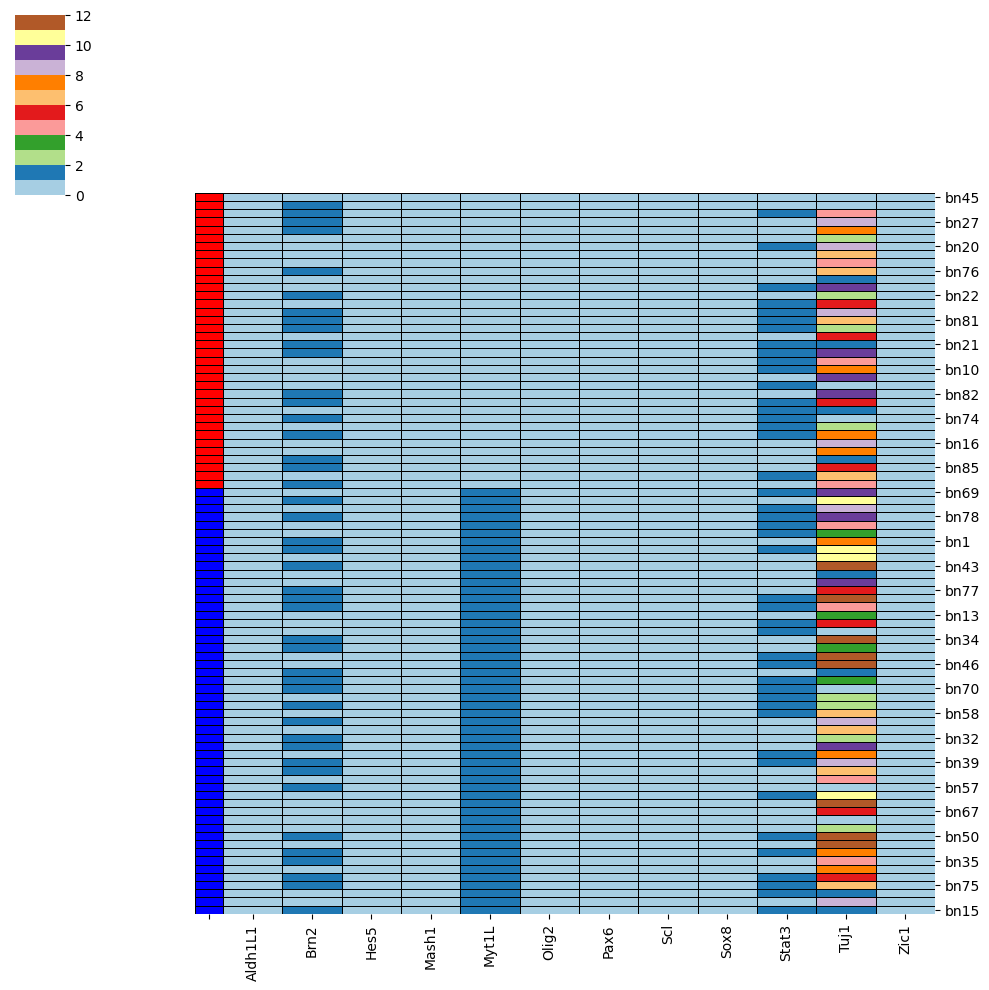

In [132]:
model_logic_categorical = model_logic.copy()
for i in model_logic_categorical.columns:
    model_logic_categorical[i], _ = pd.factorize(model_logic[i])



# Create cluster color palette
kmean_index = pd.Series(model_logic.index, index = model_logic.index)
kmean_index = kmean_index.replace(cluster_dict)
lut = dict(zip(kmean_index.unique(), "rbg"))
row_colors = kmean_index.map(lut)

sort_index = list(kmean_index.sort_values().index)

# Plot clustermap
sns.clustermap(model_logic_categorical.loc[sort_index],
            row_colors = row_colors[sort_index], 
            row_cluster=False,
            col_cluster = False,
            linecolor = 'black', linewidth = .5, 
            cmap = 'Paired')